# COVID Data examples

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import pandas as pd
import os
import soundfile as sf

**COVID data example:**  Below are some routine that allow you to easily reporduce and experiment with different filter types

In [2]:
#####################################################################################
### exploring COVID data and filtering -- ROUTINES
#####################################################################################
def filter_and_plot(b, a, x):
	y = signal.lfilter(b, a, x)
	plt.figure()
	plt.plot(x, color = 'tab:gray', label='input') # linewidth=1,
	plt.plot(y, color = 'r', label='output')
	plt.legend()
	plt.grid(linestyle=':')
	plt.xlabel("time (days)")
	plt.ylabel("signals")
	# plt.xlim([0, 100])
	#plt.ylim([-20, 2])
	plt.show()
	#plt.savefig('toy.png', dpi=256)

	return y

def read_covid_data(refresh=False):
    fname = 'data/91-DIVOC-countries.csv'
    data_url = 'http://91-divoc.com/pages/covid-visualization/?chart=countries&highlight=United%20States&show=25&y=both&scale=linear&data=cases-daily&data-source=jhu&xaxis=right#countries'
    file_downloaded = os.path.isfile(fname)
    if not file_downloaded or refresh:
        ## this does not work because of indirect linking of the CSV data on the page
        data = pd.read_csv(data_url, index_col=0, header=None).fillna(value = 0).T
    else:
        data = pd.read_csv(fname, index_col=0, header=None).fillna(value = 0).T
    
    us_data = data['United States']

    return np.asarray(us_data, dtype=np.int)

def direct_dtft(x):
    ## range of normalized frequency -- nu  in [0, 0.5]
    nu = np.arange(0, 0.5, 0.001)
    N_nu_points = len(nu)

    ### the DTFT of x
    X = np.zeros(N_nu_points, dtype=np.complex)

    ## the integer time n
    n = np.arange(len(x))

    for i in range(N_nu_points):
        dtft_exp_nu = np.exp( -2.j * np.pi * nu[i] * n)
        X[i] = np.dot(x, dtft_exp_nu)
    
    return nu, X


def plot_freq_respone(b, a, x_low=0, x_high=0.5, y_low=-60, y_high=0, freq_tag='', freq_scale=1):
    ## this computes the arma filter's frequency response from the diff. eq. coefficents
    w, H = signal.freqz(b, a, worN=2**16)
    
    plt.figure()
    nu =  ( w / ( 2 * np.pi ) ) 
    plt.plot(nu * freq_scale, 20 * np.log10(abs(H)), label='|H| (dB)')
    plt.legend()
    plt.grid(linestyle=':')
    xlims = np.asarray([x_low, x_high]) * freq_scale
    plt.xlim()
    plt.ylim([y_low, y_high])
    plt.xlabel(f'frequency {freq_tag}')
    plt.ylabel('filter gain (dB)')


Read the COVID data and then plot it in the frequency domain. Frequency is in cycles/day (cycles/sample) and is normalized (discrete time), linear frequency.  Notice there is a bit of a spike in the frequency content around 1/7 cycles/day which corresponds to a weekly fluction pattern in the data -- i.e., fewer reports over the weekend.

/Users/kmchugg/.pyenv/versions/ee301/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'signal freq. content (dB)')

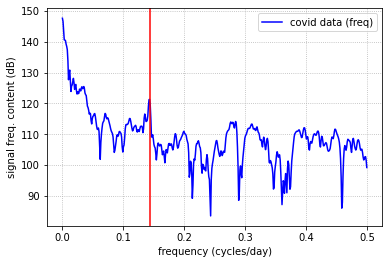

In [3]:
#####################################################################################
### exploring COVID data and filtering -- EXAMPLES
#####################################################################################
x_cov = read_covid_data()

## plot the DTFT of the data - this is the signal's frequency content
nu, X_cov = direct_dtft(x_cov)
X_cov_mag_dB = 20 * np.log10(X_cov)
plt.figure()
plt.plot(nu, X_cov_mag_dB, color = 'b', label='covid data (freq)') # linewidth=1,
plt.axvline(x=1/7, c='r')
plt.legend()
plt.grid(linestyle=':')
plt.xlabel("frequency (cycles/day)")
plt.ylabel('signal freq. content (dB)')

Below, we reproduce the 7-day averaging plots that appear on many COVID webpages -- for example [here](http://91-divoc.com/pages/covid-visualization/).  We also show the gain as a function of frequency for this 7-day averaging filter.  Notice that it has a null at frequency 1/7, but does not reject all high frequencies.  

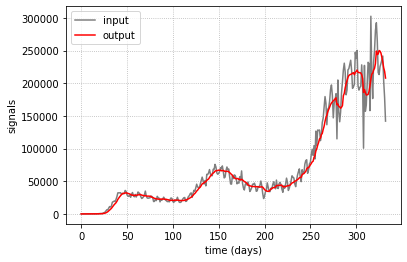

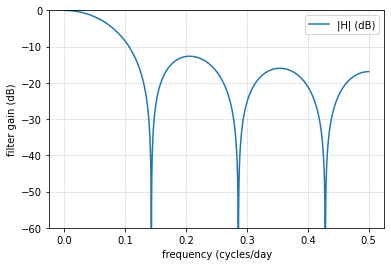

In [4]:
### seven day averaging
b7 = np.ones(7) / 7
a7 = np.asarray([1])

y7 = filter_and_plot(b7, a7, x_cov)

plot_freq_respone(b7, a7, freq_tag='(cycles/day')


We can compare this with a standard design for ARMA filters -- i.e., a butterworth filter.  Here, I have designed the filter to try to pass frequences below 1/14 and block frequencies above this value.  

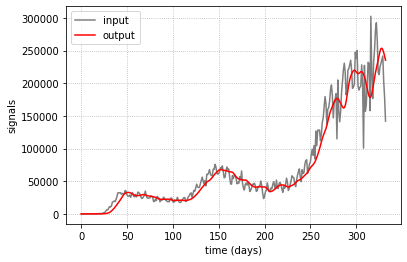

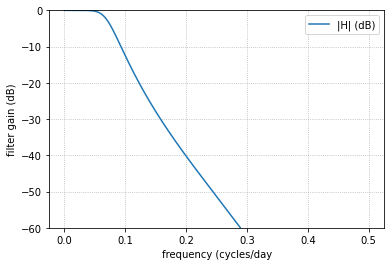

In [5]:

### butterworth filter
nu_0 = 0.5 * (1 / 7)
filter_order = 4
# b_butter, a_butter = signal.butter(2, 2 * nu_0, btype='lowpass')
b_butter, a_butter = signal.butter(filter_order, 2 * nu_0)

y_butter = filter_and_plot(b_butter, a_butter, x_cov)

plot_freq_respone(b_butter, a_butter, freq_tag='(cycles/day')


We can compare the 7-day averaging with the butterworth filter.  You can uncomment the `plt.xlim([250, 330])` to zzom in on that time range and see the differences.  You should see that there are more high-frequency ripples with the 7-day averaging and that the butterworth filter introduces some "processing delay".

Text(0, 0.5, 'signals')

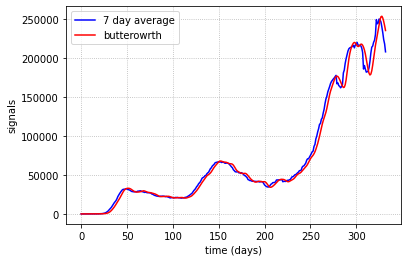

In [6]:
## compare the 2....

plt.figure()
plt.plot(y7, color = 'b', label='7 day average') # linewidth=1,
plt.plot(y_butter, color = 'r', label='butterowrth')
plt.legend()
plt.grid(linestyle=':')
# plt.xlim([250, 330])
plt.xlabel("time (days)")
plt.ylabel("signals")
